# Changes:
1. Based on salt_model_v37.4_high_lovasz_loss
2. Fine tune from IOU 0.82

## Install required packages if running on google colab

In [1]:
try:
    import torch
except:
    !pip install torch torchvision
    !pip install imageio
    !pip install Augmentor
    !git clone https://github.com/allen-q/salt_oil.git
    !git clone https://github.com/allen-q/salt_net.git

    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59d82000 @  0x7f5d86f151c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 13.9MB/s 
    100% |████████████████████████████████| 2.0MB 1.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 3.3MB 934kB/s 
  Running setup.py bdist_wheel for imageio ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio
Cloning into 'salt_oil'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/

In [2]:
cd salt_oil

/content/salt_oil


## Import required libs

In [0]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle
from salt_func_lib import *
from torchvision import transforms, utils
from skimage import io, transform
import datetime as dt
import sys
from optparse import OptionParser
import torch.backends.cudnn as cudnn
from torch import optim
from torch.optim import lr_scheduler
import copy
from io import BytesIO
import random
import PIL
import cv2 as cv
% matplotlib inline
% load_ext autoreload
% autoreload 2

## Load Unet Modules

In [0]:
from pytorch_unet.eval import eval_net
from pytorch_unet.unet import UNet
from pytorch_unet.unet.unet_parts import *
from pytorch_unet.unet.resnet import *
from pytorch_unet.utils import get_ids, split_ids, split_train_val, get_imgs_and_masks, batch

In [0]:
## Setup data type based on whether GPU is enabled

In [6]:
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!
else:    
    dtype = torch.FloatTensor
print(f'Data Type set to: {dtype}')

Data Type set to: <class 'torch.cuda.FloatTensor'>


In [0]:
def setup_train(config_list):
    for conf in config_list:
        log.info(conf)
    for conf in config_list:
        exec(conf)

## Create Logger

In [0]:
global log
log = get_logger('salt_model_v37.41_finetune')

## Prepare Data

### Load train and test data from npy files or from raw images if npy files not exist.

In [9]:
np_train_all, np_train_all_mask, X_test, misc_data = load_all_data()

Try loading data from npy and pickle files...
Data loaded.


In [0]:
'''p = Pipeline_Salt()
p.random_brightness(1,0.8,1.2)
p.random_contrast(1,0.8,1.2)
p.rotate_random_align(probability=1)
img = np.c_[np.tile(X_train[840], 2), y_train[840]]
img_in = PIL.Image.fromarray(img)
tsfm = p.torch_transform()
img_out = tsfm(img_in)
plt.imshow(np.array(img_in)[:,:,0], cmap='gray')
plt.imshow(np.array(img_out)[:,:,0], cmap='gray')'''

### Train Val data split

In [0]:
df_train_mask = pd.DataFrame((np_train_all_mask/255).sum((1,2,3)), columns=['mask_pix'])
df_train_mask.mask_pix = df_train_mask.mask_pix.round(-2)

X_train_ids, X_val_ids = (
    train_test_split(df_train_mask.index.tolist(), 
                     test_size=0.20,
                     stratify = df_train_mask.mask_pix,
                     random_state=0)
)

X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]
depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
#X_train_mean_img = X_train.mean(0).astype(np.float32)
#X_train_mean_img = X_train.mean((0,1,2)).astype(np.float32)
X_train_mean_img = np.clip(np_train_all/255, 0, 1).mean((0,1,2)).astype(np.float32)
#set mean image to 0 as mean is now being handled within the model.
X_train_mean_img = np.zeros_like(X_train_mean_img)

all_data = {
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val,
    'X_test': X_test,
    'X_train_mean_img': X_train_mean_img
}

assert X_train_mean_img == np.array([0.])
assert X_train.shape == (3200, 101, 101, 1)
assert y_train.shape == (3200, 101, 101, 1)
assert depth_train.shape == (3200, 1)

## Train the model using a small data set to see if it can overfit

In [0]:
aug_pipeline_config = '''
p = Pipeline_Salt()
p.flip_left_right(probability=0.5)
p.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)
p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)
p.rotate_random_align(probability=0.5)
p.crop_random_align(probability=0.5, min_factor=0.8, max_factor=1.0, mask_diff_pct=0.2)
'''

In [0]:
data_loader_config = '''
train_data_params = {'batch_size': 2, 'shuffle': True,}
val_data_params = {'batch_size': 2, 'shuffle': True,}
train_dataLoader = (
    DataLoader(SaltDataset(X_train[:16], y_train[:16], depth_train[:16],
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val[:8], y_val[:8], depth_val[:8], 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

'''

In [0]:
model_config = '''
saltnet = UResNet(pretrained=False)

loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()

resnet_params = (
    list(saltnet.conv1.parameters()) + 
    list(saltnet.encoder2.parameters()) + 
    list(saltnet.encoder3.parameters()) + 
    list(saltnet.encoder4.parameters()) + 
    list(saltnet.encoder5.parameters())
)

unet_params = (
    list(saltnet.center.parameters()) + 
    list(saltnet.decoder5.parameters()) + 
    list(saltnet.decoder4.parameters()) + 
    list(saltnet.decoder3.parameters()) + 
    list(saltnet.decoder2.parameters()) + 
    list(saltnet.decoder1.parameters())  + 
    list(saltnet.se_f.parameters()) + 
    list(saltnet.outc.parameters())
)

#optimizer = optim.Adam([    
#    {'params': resnet_params, 'lr': 1e-4},
#    {'params': unet_params, 'lr': 1e-3},
#])
optimizer = optim.SGD([    
    {'params': resnet_params, 'lr': 1e-4},
    {'params': unet_params, 'lr': 1e-3},
], momentum=0.9, weight_decay=0.0001)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lr_lambda_enc, lr_lambda_dec])
scheduler = PolyLR(optimizer, [1e-4, 1e-3], lr_decay_iter=1, max_iter=150, power=0.9)
model_save_name = None
'''

In [0]:
train_params_config = '''
train_params = {
    'model_save_name': None,
    'save_model_every': 10000,
    'save_log_every': 100,
    'num_epochs': 10,
    'print_every': 2,
    'log': log,
    'mask_cutoff': 0,
    'model_save_iou_threshold': 0.1
    }
'''

In [0]:
model_run_config = '''
model = train_model(saltnet, dataloaders, (loss_fn_bce, loss_lovasz_hinge), (1, 0.5), optimizer, scheduler, train_params, all_data)
'''

In [0]:
config_list = [aug_pipeline_config, data_loader_config, model_config, train_params_config, model_run_config]

In [0]:
setup_train(config_list)

## Finetune 1

In [10]:
log.info('Based on salt_model_v37.4_high_lovasz_loss. Fine tune using lavasz loss only. More data aug and L2 loss')

05/10/2018 11:23:26 - salt_model_v37.41_finetune - INFO - Based on salt_model_v37.4_high_lovasz_loss. Fine tune using lavasz loss only. More data aug and L2 loss


In [0]:
aug_pipeline_config = '''
p = Pipeline_Salt()
p.flip_left_right(probability=0.5)
p.rotate90(0.25)
p.rotate270(0.25)
p.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)
p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)
p.rotate_random_align(probability=0.6)
p.crop_random_align(probability=0.6, min_factor=0.6, max_factor=1.0, mask_diff_pct=0.2)
'''

In [0]:
data_loader_config = '''
train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}
'''

In [15]:
saltnet = UResNet(pretrained=True)

ResNet using pretrained weights.


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 24704230.85it/s]


In [0]:
model_file_suffix = "salt_model_v37.4_high_lovasz_loss_2018_10_05_10_43_22.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])

In [0]:
model_config = '''
#saltnet = UResNet(pretrained=True)
loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
resnet_params = (
    list(saltnet.conv1.parameters()) + 
    list(saltnet.encoder2.parameters()) + 
    list(saltnet.encoder3.parameters()) + 
    list(saltnet.encoder4.parameters()) + 
    list(saltnet.encoder5.parameters())
)

unet_params = (
    list(saltnet.center.parameters()) + 
    list(saltnet.decoder5.parameters()) + 
    list(saltnet.decoder4.parameters()) + 
    list(saltnet.decoder3.parameters()) + 
    list(saltnet.decoder2.parameters()) + 
    list(saltnet.decoder1.parameters())  + 
    list(saltnet.se_f.parameters()) + 
    list(saltnet.outc.parameters())
)
optimizer = optim.Adam([    
    {'params': resnet_params, 'lr': 5e-5},
    {'params': unet_params, 'lr': 5e-4},
], weight_decay=0.0002)
#optimizer = optim.SGD([    
#    {'params': resnet_params, 'lr': 1e-4},
#    {'params': unet_params, 'lr': 1e-3},
#], momentum=0.9, weight_decay=0.00001)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, min_lr=0.00001)
scheduler = PolyLR(optimizer, [5e-5, 5e-4], lr_decay_iter=1, max_iter=50, power=0.9)
model_save_name = f'../salt_net/salt_model_v37.41_finetune1_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)
'''

In [0]:
train_params_config = '''
train_params = {
    'model_save_name': model_save_name,
    'save_model_every': 20,
    'save_log_every': 2,
    'num_epochs': 50,
    'log': log,
    'mask_cutoff': 0.,
    'model_save_iou_threshold': 0.825
    }
'''

In [0]:
model_run_config = '''
train_model(saltnet, dataloaders, (loss_lovasz_hinge, ), (1, ), optimizer, scheduler, train_params, all_data)
'''

In [0]:
config_list = [aug_pipeline_config, data_loader_config, model_config, train_params_config, model_run_config]

05/10/2018 11:27:26 - salt_model_v37.41_finetune - INFO - 
p = Pipeline_Salt()
p.flip_left_right(probability=0.5)
p.rotate90(0.25)
p.rotate270(0.25)
p.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)
p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)
p.rotate_random_align(probability=0.6)
p.crop_random_align(probability=0.6, min_factor=0.6, max_factor=1.0, mask_diff_pct=0.2)

05/10/2018 11:27:26 - salt_model_v37.41_finetune - INFO - 
train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **train_data_params)
)

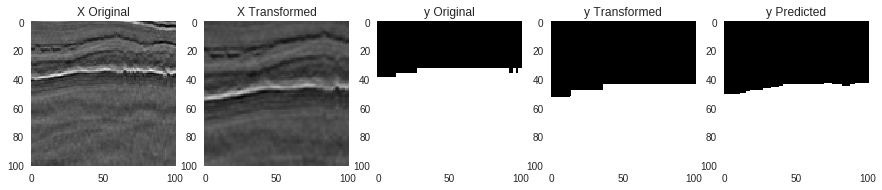

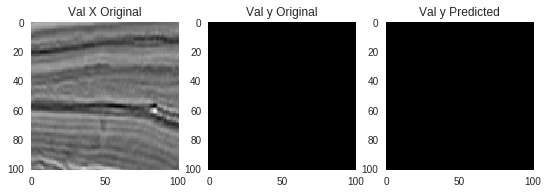

05/10/2018 11:31:15 - salt_model_v37.41_finetune - INFO - ['../salt_net/salt_model_v37.41_finetune1_2018_10_05_21_27_26.ckp-chunk-1-Of-10', '../salt_net/salt_model_v37.41_finetune1_2018_10_05_21_27_26.ckp-chunk-2-Of-10', '../salt_net/salt_model_v37.41_finetune1_2018_10_05_21_27_26.ckp-chunk-3-Of-10', '../salt_net/salt_model_v37.41_finetune1_2018_10_05_21_27_26.ckp-chunk-4-Of-10', '../salt_net/salt_model_v37.41_finetune1_2018_10_05_21_27_26.ckp-chunk-5-Of-10', '../salt_net/salt_model_v37.41_finetune1_2018_10_05_21_27_26.ckp-chunk-6-Of-10', '../salt_net/salt_model_v37.41_finetune1_2018_10_05_21_27_26.ckp-chunk-7-Of-10', '../salt_net/salt_model_v37.41_finetune1_2018_10_05_21_27_26.ckp-chunk-8-Of-10', '../salt_net/salt_model_v37.41_finetune1_2018_10_05_21_27_26.ckp-chunk-9-Of-10', '../salt_net/salt_model_v37.41_finetune1_2018_10_05_21_27_26.ckp-chunk-10-Of-10']
05/10/2018 11:31:15 - salt_model_v37.41_finetune - INFO - Best Val Mean IOU so far: 0.806125
05/10/2018 11:31:15 - salt_model_v37.

/content/salt_net
Already up-to-date.
[master c82db5b] Pushing logs to git
 2 files changed, 196 insertions(+)
 create mode 100644 logs/SaltNet_2018_10_05_21h.log
 create mode 100644 logs/salt_model_v37.41_finetune_2018_10_05_21h.log
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1.96 KiB | 1.96 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/allen-q/salt_net.git
   1bc09d6..c82db5b  master -> master


05/10/2018 11:35:20 - salt_model_v37.41_finetune - INFO - Train IOU: 0.8471, Acc: 0.9676, Loss: [0.2596, 0.2596] at epoch 2


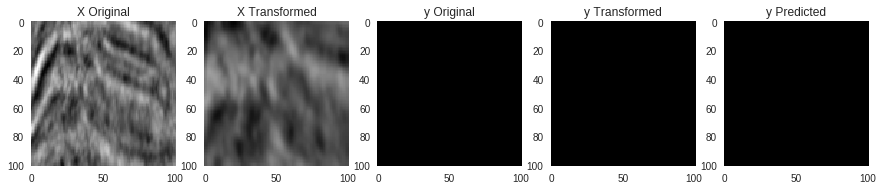

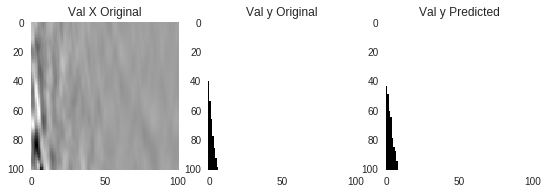

05/10/2018 11:35:35 - salt_model_v37.41_finetune - INFO - Val   IOU: 0.7999, Acc: 0.9561, Best Val IOU: 0.8061 at epoch 2
05/10/2018 11:35:36 - salt_model_v37.41_finetune - INFO - LR: [4.82e-05, 0.000482]
05/10/2018 11:35:36 - salt_model_v37.41_finetune - INFO - Epoch 3/50
05/10/2018 11:35:36 - salt_model_v37.41_finetune - INFO - --------------------


In [0]:
setup_train(config_list)

## Finetune 2

In [0]:
log.info('Based on salt_model_v37.4_high_lovasz_loss. Fine tune using lavasz loss and focal loss. More data aug and L2 loss, smaller batch.')

05/10/2018 11:23:26 - salt_model_v37.41_finetune - INFO - Based on salt_model_v37.4_high_lovasz_loss. Fine tune using lavasz loss only. More data aug and L2 loss


In [0]:
aug_pipeline_config = '''
p = Pipeline_Salt()
p.skew(probability=0.5, magnitude=0.2)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.flip_left_right(probability=0.5)
p.rotate90(0.25)
p.rotate270(0.25)
p.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)
p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)
p.rotate_random_align(probability=0.6)
p.crop_random_align(probability=0.6, min_factor=0.6, max_factor=1.0, mask_diff_pct=0.2)
'''

In [0]:
data_loader_config = '''
train_data_params = {'batch_size': 16,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': False}

val_data_params = {'batch_size': 16,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}
'''

In [0]:
saltnet = UResNet(pretrained=True)

In [0]:
cd ../salt_net

In [0]:
model_file_suffix = "salt_model_v37.4_high_lovasz_loss_2018_10_05_10_43_22.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])

In [0]:
model_config = '''
#saltnet = UResNet(pretrained=True)
#loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
resnet_params = (
    list(saltnet.conv1.parameters()) + 
    list(saltnet.encoder2.parameters()) + 
    list(saltnet.encoder3.parameters()) + 
    list(saltnet.encoder4.parameters()) + 
    list(saltnet.encoder5.parameters())
)

unet_params = (
    list(saltnet.center.parameters()) + 
    list(saltnet.decoder5.parameters()) + 
    list(saltnet.decoder4.parameters()) + 
    list(saltnet.decoder3.parameters()) + 
    list(saltnet.decoder2.parameters()) + 
    list(saltnet.decoder1.parameters())  + 
    list(saltnet.se_f.parameters()) + 
    list(saltnet.outc.parameters())
)
optimizer = optim.Adam([    
    {'params': resnet_params, 'lr': 5e-5},
    {'params': unet_params, 'lr': 5e-4},
], weight_decay=0.0002)
#optimizer = optim.SGD([    
#    {'params': resnet_params, 'lr': 1e-4},
#    {'params': unet_params, 'lr': 1e-3},
#], momentum=0.9, weight_decay=0.00001)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, min_lr=0.00001)
scheduler = PolyLR(optimizer, [5e-5, 5e-4], lr_decay_iter=1, max_iter=150, power=0.9)
model_save_name = f'../salt_net/salt_model_v37.41_finetune2_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)
'''

In [0]:
train_params_config = '''
train_params = {
    'model_save_name': model_save_name,
    'save_model_every': 20,
    'save_log_every': 2,
    'num_epochs': 150,
    'log': log,
    'mask_cutoff': 0.,
    'model_save_iou_threshold': 0.825
    }
'''

In [0]:
model_run_config = '''
train_model(saltnet, dataloaders, (loss_lovasz_hinge, loss_focal), (1, 1), optimizer, scheduler, train_params, all_data)
'''

In [0]:
config_list = [aug_pipeline_config, data_loader_config, model_config, train_params_config, model_run_config]

In [0]:
setup_train(config_list)

## Load Trained Model

In [0]:
loaded_model = saltnet

In [0]:
loaded_model = UResNet(pretrained=False)

In [0]:
ls

In [0]:
cd ../salt_net

In [0]:
ls

In [0]:
model_file_suffix = "Unet_res34_bce_lovasz_loss_se_new_aug_finetuen1_2018_09_21_09_41_48.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
loaded_model.load_state_dict(model_state_dict['model'])

### Make Predictions on validation set

### Set model to evaluation mode

In [0]:
loaded_model.eval()
assert loaded_model.training == False

In [0]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img, out_size=128), batch_size=16)

In [0]:
if torch.cuda.is_available():
    loaded_model.cuda()

### Eval model on Val data set

In [0]:
y_val_pred = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred.append(loaded_model(X_val_batch))
y_val_pred = torch.cat(y_val_pred)

In [0]:
p = Pipeline_Salt()
p.flip_left_right(probability=1)
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img, out_size=128, out_ch=1,
                           transform=p.torch_transform()), batch_size=16)
y_val_pred_flip = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred_flip.append(loaded_model(X_val_batch))
y_val_pred_flip = torch.cat(y_val_pred_flip)
y_val_pred_flip = torch.flip(y_val_pred_flip,[2])

#### merge normal pred and hflip pred

In [0]:
y_val_pred_ens = torch.where(y_val_pred.abs() > y_val_pred_flip.abs(), y_val_pred, y_val_pred_flip)

#### Check normal pred IOU

In [0]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred.gt(0), y_val.squeeze())

#### Check TTA pred IOU

In [0]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred_ens.gt(0), y_val.squeeze())

### Find best mask cutoff

In [0]:
results=[]
for cut_off in np.r_[-0.1:0.1:50j]:
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(0, X_val, y_val_pred_ens.gt(cut_off), y_val.squeeze()), y_val.squeeze()))

In [0]:
MASK_CUTOFF = np.r_[-0.1:0.1:50j][np.argmax(results)]

In [0]:
print(f'MASK_CUTOFF: {MASK_CUTOFF}')

#### Find best ZERO_MASK_CUTOFF

In [0]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_val, y_val_pred_ens.gt(MASK_CUTOFF), y_val.squeeze()), y_val.squeeze()))

In [0]:
ZERO_MASK_CUTOFF = range(0, 300, 10)[np.argmax(results)]

In [0]:
print(f'ZERO_MASK_CUTOFF: {ZERO_MASK_CUTOFF}')

In [0]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred_ens.gt(MASK_CUTOFF), y_val.squeeze())

### View a few val images with predictions

In [0]:
for i in range(10):
    rand_id = np.random.choice(X_val_id_batch)
    print(f'Image ID: {rand_id}')
    val_img = X_val[rand_id]/255
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred_ens.ge(MASK_CUTOFF)[rand_id]
    plot_img_mask_pred([val_img, val_mask, val_mask_pred], range(3), img_per_line=3)

### Eval model on Train data set

In [0]:
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img, out_size=128), batch_size=32)
y_train_pred = []

with torch.no_grad():
    for X_train_batch, y_train_batch, depth_train_batch, X_train_id_batch in train_dataLoader:
        y_train_pred.append(loaded_model(X_train_batch))
y_train_pred = torch.cat(y_train_pred)

In [0]:
p = Pipeline_Salt()
p.flip_left_right(probability=1)
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img, out_size=128, out_ch=1,
                           transform=p.torch_transform()), batch_size=32)
y_train_pred_flip = []

with torch.no_grad():
    for X_train_batch, y_train_batch, depth_train_batch, X_train_id_batch in train_dataLoader:
        y_train_pred_flip.append(loaded_model(X_train_batch))
y_train_pred_flip = torch.cat(y_train_pred_flip)
y_train_pred_flip = torch.flip(y_train_pred_flip,[2])

#### merge normal pred and hflip pred

In [0]:
y_train_pred_ens = torch.where(y_train_pred.abs() > y_train_pred_flip.abs(), y_train_pred, y_train_pred_flip)

#### Check normal pred IOU

In [0]:
y_train_pred_adj = adjust_predictions(0, X_train, y_train_pred.gt(0), y_train.squeeze())

#### Check TTA pred IOU

In [0]:
y_train_pred_adj = adjust_predictions(0, X_train, y_train_pred_ens.gt(0), y_train.squeeze())

### Find best mask cutoff

In [0]:
results=[]
for cut_off in np.r_[-0.2:0.2:50j]:
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(0, X_train, y_train_pred_ens.gt(cut_off), y_train.squeeze()), y_train.squeeze()))

In [0]:
np.r_[-0.2:0.2:50j][np.argmax(results)]

In [0]:
MASK_CUTOFF = np.r_[-0.1:0.1:50j][np.argmax(results)]

In [0]:
MASK_CUTOFF = 0

In [0]:
print(f'MASK_CUTOFF: {MASK_CUTOFF}')

#### Find best ZERO_MASK_CUTOFF

In [0]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_train, y_train_pred_ens.gt(MASK_CUTOFF), y_train.squeeze()), y_train.squeeze()))

In [0]:
ZERO_MASK_CUTOFF = range(0, 300, 10)[np.argmax(results)]

In [0]:
print(f'ZERO_MASK_CUTOFF: {ZERO_MASK_CUTOFF}')

In [0]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred_ens.gt(MASK_CUTOFF), y_val.squeeze())

In [0]:
y_train_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_train, y_train_pred_ens.gt(MASK_CUTOFF), y_train.squeeze())

In [0]:
for i in range(10):
    rand_id = np.random.choice(X_train_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_train[rand_id]/255
    mask = y_train[rand_id]
    mask_pred = y_train_pred.ge(MASK_CUTOFF)[rand_id]
    plot_img_mask_pred([img, mask, mask_pred], range(3), img_per_line=3)

## Make predictions on test set using TTA

In [0]:
import numpy as np

### Predict using original image

In [0]:
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128), batch_size=32)

In [0]:
y_test_pred_raw = []
with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_raw.append(loaded_model(X_test_batch))
y_test_pred = torch.cat(y_test_pred_raw)

### Predict using flipped images

In [0]:
p = Pipeline_Salt()
p.flip_left_right(probability=1)
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128, out_ch=1,
                           transform=p.torch_transform()), batch_size=32)
y_test_pred_flip = []

with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_flip.append(loaded_model(X_test_batch))
y_test_pred_flip = torch.cat(y_test_pred_flip)
y_test_pred_flip = torch.flip(y_test_pred_flip,[2])

### Combine non-flip and flip predictions

In [0]:
y_test_pred = torch.where(y_test_pred.abs() > y_test_pred_flip.abs(), y_test_pred, y_test_pred_flip)

### Adjust predictions

In [0]:
MASK_CUTOFF = 0
ZERO_MASK_CUTOFF = 0

In [0]:
print(f'MASK_CUTOFF:{MASK_CUTOFF}, ZERO_MASK_CUTOFF:{ZERO_MASK_CUTOFF}')

In [0]:
y_test_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_test, y_test_pred.gt(MASK_CUTOFF))


### Show segmentation masks for a few images

In [0]:
for i in range(10):
    rand_id = np.random.choice(X_test_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_test[rand_id]/255
    mask_pred = y_test_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([img, mask_pred], range(2))

### Prepare for submission

In [0]:
y_test_pred_rle = rle_encoder3d(y_test_pred_adj)

In [0]:
y_test_pred_adj.shape

In [0]:
df_test_rle = pd.DataFrame(index=misc_data['np_test_ids'], data=y_test_pred_rle).reset_index()

In [0]:
df_test_rle.columns = ['id', 'rle_mask']

In [0]:
df_test_rle[df_test_rle.rle_mask==''].shape

In [0]:
df_test_rle.shape

In [0]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)

In [0]:
ls

In [0]:
from google.colab import files


In [0]:
files.download('submission_2018_09_21_13_11_16.csv') 